# Pipeline benchmarks

## Setup

In [1]:
from pathlib import Path
from typing import Optional

import janitor  # noqa: F401
import pandas as pd
import seaborn as sns

from speclet.io import project_root

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
benchmark_dir = project_root() / "benchmarks"
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [4]:
list(benchmark_dir.iterdir())

[PosixPath('/Users/admin/Developer/haigis-lab/speclet/benchmarks/.DS_Store'),
 PosixPath('/Users/admin/Developer/haigis-lab/speclet/benchmarks/010_010_model-fitting-pipeline')]

In [5]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(
    rule_d: Path, pipeline_name: str
) -> Optional[pd.DataFrame]:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    if len(bench_dfs) == 0:
        return None

    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    if pipeline_dir.name in {".DS_Store"}:
        continue
    for rule_dir in pipeline_dir.iterdir():
        df = get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        if df is not None:
            benchmark_df_list.append(df)

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,47.7928,0:00:47,-,-,-,-,-,-,0.0,0,example-specification_chain0,sample_pymc3_mcmc,010_010_model-fitting-pipeline
1,51.1992,0:00:51,-,-,-,-,-,-,0.0,0,example-specification_chain1,sample_pymc3_mcmc,010_010_model-fitting-pipeline
2,46.0756,0:00:46,-,-,-,-,-,-,0.0,0,example-specification_chain0,sample_stan_mcmc,010_010_model-fitting-pipeline
3,77.1862,0:01:17,-,-,-,-,-,-,0.0,0,example-specification_chain1,sample_stan_mcmc,010_010_model-fitting-pipeline
4,104.1671,0:01:44,-,-,-,-,-,-,0.0,0,example-specification,sample_pymc3_advi,010_010_model-fitting-pipeline


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [6]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  mean_load  cpu_time
pipeline                       rule                                          
010_010_model-fitting-pipeline sample_pymc3_advi  104.17        0.0       0.0
                               sample_pymc3_mcmc   49.50        0.0       0.0
                               sample_stan_mcmc    61.63        0.0       0.0

In [7]:
benchmark_df_long = (
    benchmark_df[
        ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
    ]
    .pivot_longer(["pipeline", "rule", "step"])
    .query("value != '-'")
    .astype({"value": float})
)

benchmark_df_long.head()

,pipeline,rule,step,variable,value
0,010_010_model-fitting-pipeline,sample_pymc3_mcmc,example-specification_chain0,cpu_time,0.0
1,010_010_model-fitting-pipeline,sample_pymc3_mcmc,example-specification_chain1,cpu_time,0.0
2,010_010_model-fitting-pipeline,sample_stan_mcmc,example-specification_chain0,cpu_time,0.0
3,010_010_model-fitting-pipeline,sample_stan_mcmc,example-specification_chain1,cpu_time,0.0
4,010_010_model-fitting-pipeline,sample_pymc3_advi,example-specification,cpu_time,0.0


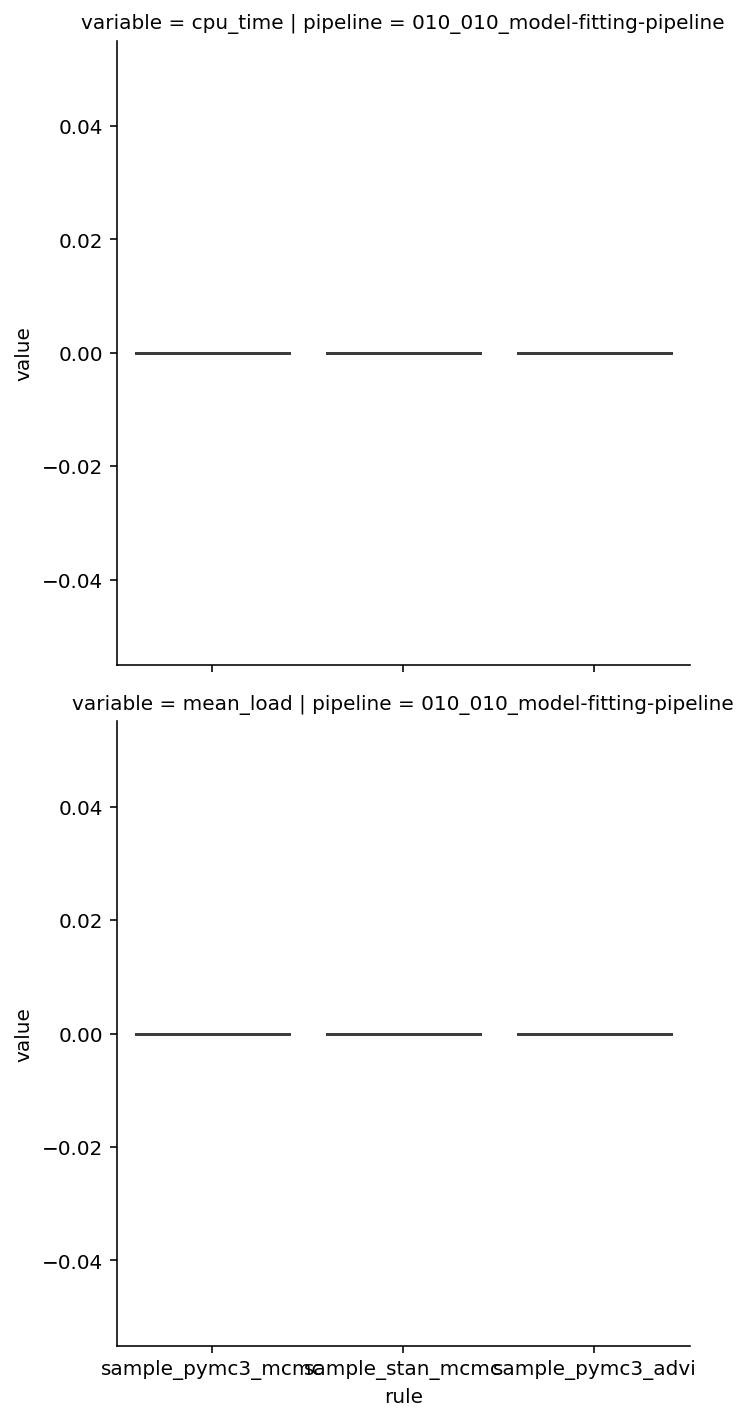

In [8]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
)

---

In [9]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-01-13

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: refactor-stan

pandas : 1.3.5
janitor: 0.22.0
seaborn: 0.11.2

